# ID5030 Assignment - 8
### Physics Informed Neural Networks

By: P Akhil Reddy    
Roll No: CH20B076

### Question 1-a: Solving the 1-D advection equation using the PINN.
### (Using PyTorch)

In [1]:
import torch
import torch.nn as nn
import torch.autograd as ag
import numpy as np
from random import uniform

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#### Defining the PINN class.

In [2]:
class PINN():
    def __init__(self, X_u, u, X_f, lr=1, max_epochs=50000):
        # collocation points:
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

        self.t_f = torch.tensor(X_f[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

        # Null vector for testing against collocation points f:
        self.null =  torch.zeros((self.x_f.shape[0], 1))

        # Solution for Boundary:
        self.u = torch.tensor(u, dtype=torch.float32)

        # boundary condition:
        self.x_u = torch.tensor(X_u[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

        self.t_u = torch.tensor(X_u[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

        # Defining the neural network which approximates the PDE function
        self.net = nn.Sequential(
            nn.Linear(2, 10), nn.Tanh(),
            nn.Linear(10, 10), nn.Tanh(),
            nn.Linear(10, 10), nn.Tanh(),
            nn.Linear(10, 10), nn.Tanh(),
            nn.Linear(10, 10), nn.Tanh(),
            nn.Linear(10, 10), nn.Tanh(),
            nn.Linear(10, 1))
        
        # Constant used in 1-D advection equation
        self.a = 0.15

        self.net_params = self.net.parameters()
        self.lr = lr
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss()
        self.calc_loss = 0
        self.epoch_num = 0
        self.history_size = 100

        # Optimizer which updates the weights and biases of the net:
        self.optimizer = torch.optim.LBFGS(self.net_params,
                                    lr=self.lr,
                                    max_iter=self.max_epochs,
                                    max_eval=self.max_epochs*1.25,
                                    history_size=self.history_size,
                                    tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
        
    def pred_u(self, x, t):
        u = self.net( torch.hstack((x, t)) )
        return u

    def pred_f(self, x, t):# Null vector for testing against collocation points f:
        self.null =  torch.zeros((self.x_f.shape[0], 1))
        """Physics based function which appromixates the function value"""
        u = self.pred_u(x, t)
        
        # Computing the time derivative
        u_t = ag.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        # Computing the derivative with respect to x
        u_x = ag.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        return u_t + (self.a * u_x)

    def train_step(self):
        self.optimizer.zero_grad()
        
        # Predictions for u and f
        u_prediction = self.pred_u(self.x_u, self.t_u)
        f_prediction = self.pred_f(self.x_f, self.t_f)

        self.calc_loss = self.loss(u_prediction, self.u) + self.loss(f_prediction, self.null)

        # Backpropagation
        self.calc_loss.backward()

        # Printing loss after every 100 epochs
        if (self.epoch_num % 100 == 0):
            print(f"At epoch: {self.epoch_num}, loss: {self.calc_loss:8.4f}")

        self.epoch_num += 1
        
        return self.calc_loss
        
    def train_model(self):
        """ training loop """
        self.net.train()
        self.optimizer.step(self.train_step)

    def plot(self):
        """ Function for plotting the solution on new data """
        x = torch.linspace(-1, 1, 200)
        t = torch.linspace( 0, 1, 100)
        x_mesh, t_mesh = torch.meshgrid(x, t)

        x_col = x_mesh.reshape(-1, 1)
        t_col = t_mesh.reshape(-1, 1)

        usol = self.pred_u(x_col, t_col)

        U = usol.reshape(x.numel(), t.numel()).detach().numpy()

        x_np = x.numpy()
        t_np = t.numpy()

        # Creating figure
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111)
        ax.set_xlabel("Time t")
        ax.set_ylabel("Distance x")
        ax.set_title("Solution plot of 1-D advection equation")

        h = ax.imshow(U, interpolation='nearest', cmap='turbo', extent=[t_np.min(), t_np.max(), x_np.min(), x_np.max()], origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()


### Defining all the hyperparameters and processing the dataset to be loaded into the model.

In [3]:
num_boun = 100            # number of data points in the boundaries             
num_colloc = 10000        # Number of collocation points          
lr = 1                    # Learning rate
max_epochs = 5000         # Maximum number of epochs
boun_size1 = num_boun//4
boun_size2 = num_boun//2

x_upper = np.ones((boun_size1, 1), dtype=float)
x_lower = (-1) * np.ones((boun_size1, 1), dtype=float)
x_zero = (-1) + 2*np.random.rand(boun_size2, 1)

t_upper = np.random.rand(boun_size1, 1)
t_lower = np.random.rand(boun_size1, 1)
t_zero = np.zeros((boun_size2, 1), dtype=float)

# Stack uppers, lowers and zero arrays of X
X_upper = np.hstack( (x_upper, t_upper) )
X_lower = np.hstack( (x_lower, t_lower) )
X_zero = np.hstack( (x_zero, t_zero) )

# Stack the arrays to form X_u_train - the boundary condition dataset
# And then shuffle the boundary train dataset
index = np.arange(0, num_boun)
np.random.shuffle(index)
X_u_train = np.vstack( (X_upper, X_lower, X_zero) )
X_u_train = X_u_train[index, :]
    
# Make X_f_train
X_f_train = np.zeros((num_colloc, 2), dtype=float)
for i in range(num_colloc):
    X_f_train[i, 0] = uniform(-1, 1)
    X_f_train[i, 1] = uniform(0, 1)

# Adding the boundary points to the collocation points
X_f_train = np.vstack( (X_f_train, X_u_train) )

u_upper =  np.zeros((boun_size1, 1), dtype=float)
u_lower =  np.zeros((boun_size1, 1), dtype=float) 
u_zero = -np.sin(np.pi * x_zero)  

# Stacking and shuffling the u_train in the same way as X_u_train was shuffled
u_train = np.vstack( (u_upper, u_lower, u_zero) )
u_train = u_train[index, :]

# Creating a PINN model with the datasets
pinn = PINN(X_u_train, u_train, X_f_train, lr=lr, max_epochs=max_epochs)

### Training the model

In [4]:
pinn.train_model()

/home/akhil/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:300: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


At epoch: 0, loss:   0.3231
At epoch: 100, loss:   0.0079
At epoch: 200, loss:   0.0067
At epoch: 300, loss:   0.0063
At epoch: 400, loss:   0.0059
At epoch: 500, loss:   0.0055
At epoch: 600, loss:   0.0053
At epoch: 700, loss:   0.0052
At epoch: 800, loss:   0.0048
At epoch: 900, loss:   0.0048
At epoch: 1000, loss:   0.0043
At epoch: 1100, loss:   0.0042
At epoch: 1200, loss:   0.0041
At epoch: 1300, loss:   0.0039
At epoch: 1400, loss:   0.0037
At epoch: 1500, loss:   0.0035
At epoch: 1600, loss:   0.0033


### Plotting the predictions on new data, i.e., the solution of the 1-D advection equation.

/home/akhil/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


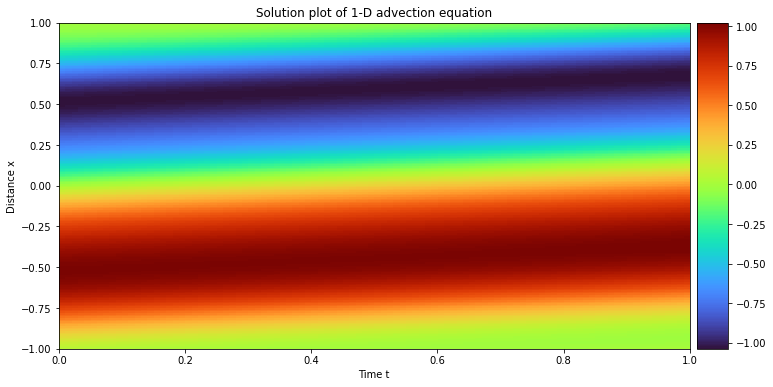

In [5]:
pinn.plot()

### Part 1-b: Discussion of the results.

<a href="https://peymandavvalo.github.io/linear_1d_advection_equation.html">Link to page containing actual solution of advection equation</a>

#### It has been observed that the results obtained are matching with the solution discussed in the above paper. In our solution obtained using PINNs, we observe that the peak and the trough shift in the positive x-direction with time t.

#### The same result is discussed in the part 3 of the paper, where the peak shifts in positive x-direction with time t. Also it should be noted that the height of the peak decreases with time. This is also observed in our solution where height of the peak slightly decreases with time, although it is not clearly visible.